Fit CNN in PyTorch
===


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# number of models
n_ensemble = 2

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 10
num_epochs_ft = 10

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
#dropout = 0.5   
#n_dense = 256
#n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

img_dir = "../sanders_2018/360 Rocks"
csv_file = "../finetuning_torchvision_data/mds_360.csv"

## Functions and classes

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        global tmp_labels, tmp_outputs
                        tmp_labels = labels
                        tmp_outputs = outputs
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics # TODO -> check if this is correct (maybe calculate MSE?)
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_r2 / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
    
    # maybe not necessary, but lets check later if it's a handy feature
    
   #     # save model after each epoch
   #     torch.save({
   #         'epoch': epoch,
   #         'model_state_dict': model.state_dict(),
   #         'optimizer_state_dict': optimizer.state_dict(),
   #         'loss': loss,
   #         ...
   #         }, PATH)
    
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(Dataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_img(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

## Load Data

In [4]:
df = pd.read_csv(csv_file)

train, test = train_test_split(df, test_size=90, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), img_dir)
test_dataset = RocksData(test.reset_index(drop=True), img_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
test_loader = DataLoader(test_dataset, batch_size=batch_size_im)

dataloaders_dict = {"train":train_loader,"val":test_loader}

## Create intermediate model

In [5]:
# TODO change later from resnet18 to resnet50
model_im = models.resnet50(pretrained=True)
set_parameter_requires_grad(model_im, feature_extract_im)
num_ftrs = model_im.fc.in_features
model_im.fc = nn.Linear(num_ftrs, num_classes)

### Optimizer

In [6]:
loglr = -2.2200654426745987
lr_im = 10 ** loglr

# Send the model to GPU
model_im = model_im.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update_im = model_im.parameters()
print("Params to learn:")
if feature_extract_im:
    params_to_update_im = []
    for name,param in model_im.named_parameters():
        if param.requires_grad == True:
            params_to_update_im.append(param)
            print("\t",name)
else:
    for name,param in model_im.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_im = optim.Adam(params_to_update_im, lr = lr_im) # for the intermediate model

Params to learn:
	 fc.weight
	 fc.bias


### Run Training and Validation Step

**Intermediate model**

In [7]:
# Setup the loss fxn

loss_name = "L2"

if loss_name == "L1":
    criterion = torch.nn.L1Loss()
elif loss_name == "L2":
    criterion = torch.nn.MSELoss()
elif loss_name == "smooth_L1":
    criterion = torch.nn.SmoothL1Loss()
elif loss_name == "huber":
    criterion = torch.nn.HuberLoss()

# Train and evaluate
model_ft, hist = train_model(model_im, dataloaders_dict, criterion, optimizer_im, num_epochs = num_epochs_im)

Epoch 1/10
----------
train Loss:  9.7773 Acc: -12144.9969
val Loss:  6.0561 Acc: -7052.9219

Epoch 2/10
----------
train Loss:  11.5043 Acc: -13758.8084
val Loss:  2.4114 Acc: -3235.5758

Epoch 3/10
----------
train Loss:  2.7730 Acc: -3098.3288
val Loss:  7.3521 Acc: -8877.2171

Epoch 4/10
----------
train Loss:  5.6711 Acc: -6987.3499
val Loss:  0.6303 Acc: -634.5928

Epoch 5/10
----------
train Loss:  1.7108 Acc: -1852.9455
val Loss:  4.0021 Acc: -5090.3279

Epoch 6/10
----------
train Loss:  2.7634 Acc: -3436.7537
val Loss:  0.4345 Acc: -387.5039

Epoch 7/10
----------
train Loss:  1.0331 Acc: -1128.6442
val Loss:  2.1241 Acc: -2683.3799

Epoch 8/10
----------
train Loss:  1.4283 Acc: -1775.8307
val Loss:  0.2312 Acc: -190.3409

Epoch 9/10
----------
train Loss:  0.6466 Acc: -719.6060
val Loss:  1.2036 Acc: -1546.9021

Epoch 10/10
----------
train Loss:  0.7061 Acc: -877.6936
val Loss:  0.1694 Acc: -150.5845

Training complete in 8m 36s
Best val Acc: -150.584531


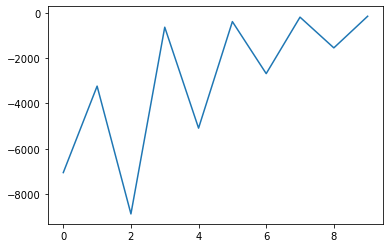

In [9]:
plt.plot(hist)

## Create finetuned model

### Set all parameters to trainable

In [10]:
set_parameter_requires_grad(model_ft, feature_extract_ft)

### different batch size

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)

dataloaders_dict = {"train":train_loader,"val":test_loader}

### Optimizer

In [12]:
lr_ft = 0.0001

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update_ft = model_ft.parameters()
print("Params to learn:")
if feature_extract_ft:
    params_to_update_ft = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update_ft.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update_ft, lr = lr_ft, momentum = 0.9) # for the finetuning

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

### Run Training and Validation Step

**Finetuned model**

In [13]:
# Setup the loss fxn

loss_name = "L2"

if loss_name == "L1":
    criterion = torch.nn.L1Loss()
elif loss_name == "L2":
    criterion = torch.nn.MSELoss()
elif loss_name == "smooth_L1":
    criterion = torch.nn.SmoothL1Loss()
elif loss_name == "huber":
    criterion = torch.nn.HuberLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = num_epochs_ft)

Epoch 1/10
----------
train Loss:  0.1297 Acc: -396.6943
val Loss:  0.0826 Acc: -242.5176

Epoch 2/10
----------
train Loss:  0.0417 Acc: -135.9795
val Loss:  0.0253 Acc: -90.7142

Epoch 3/10
----------
train Loss:  0.0161 Acc: -59.5197
val Loss:  0.0251 Acc: -91.3627

Epoch 4/10
----------
train Loss:  0.0189 Acc: -67.7675
val Loss:  0.0258 Acc: -93.2126

Epoch 5/10
----------
train Loss:  0.0169 Acc: -61.7785
val Loss:  0.0228 Acc: -84.6623

Epoch 6/10
----------
train Loss:  0.0144 Acc: -54.0612
val Loss:  0.0221 Acc: -82.1184

Epoch 7/10
----------
train Loss:  0.0139 Acc: -52.3246
val Loss:  0.0222 Acc: -82.1494

Epoch 8/10
----------
train Loss:  0.0137 Acc: -51.5530
val Loss:  0.0220 Acc: -81.5335

Epoch 9/10
----------
train Loss:  0.0134 Acc: -50.3356
val Loss:  0.0217 Acc: -80.8133

Epoch 10/10
----------
train Loss:  0.0131 Acc: -49.2617
val Loss:  0.0216 Acc: -80.3180

Training complete in 31m 47s
Best val Acc: -80.317964


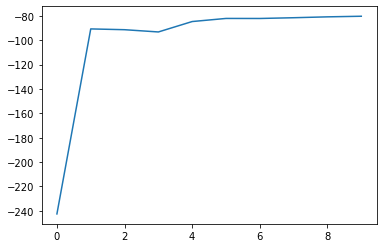

In [15]:
plt.plot(hist)

## Save model

In [16]:
PATH = "CNN_checkpoints/state_dict_model_ft.pt"
torch.save(model_ft.state_dict(), PATH)

## Load model

In [ ]:
model_ft = models.resnet50()
set_parameter_requires_grad(model_ft, feature_extract_ft)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft.load_state_dict(torch.load(PATH))

model_ft.eval()